# Projekt MSP1

__Autor:__

David Chocholatý, xchoch09

## Úloha 1 - Bayesovské odhady

### a) Konjugované apriorní a aposteriorní rozdělení, prediktivní rozdělení

- počet připojení za 1 ms popsaný 𝑋~𝑃𝑜(𝜆)
- expertní odhad: každých 5 ms by mělo nastat 10 připojení
- máme pozorování za dobu 100 ms


In [1]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.formula.api as smf
import numpy as np

In [2]:
df_1 = pd.read_excel(open('Projekt-2_Data.xlsx', 'rb'), sheet_name='Úloha 1')
df_1

,uloha_1 a),uloha_1 b)_prior,skupina,uloha_1 b)_pozorování
0,2.0,3.634785,0,3.626656
1,2.0,2.868113,0,3.008269
2,1.0,2.149160,0,2.989829
3,3.0,4.263065,0,2.371630
4,0.0,2.594745,0,4.009366
...,...,...,...,...
99995,NaN,1.725637,9999,NaN
99996,NaN,4.048414,9999,NaN
99997,NaN,3.000662,9999,NaN
99998,NaN,3.058451,9999,NaN


In [3]:
OBSERVATIONS_COUNT = 100

observations = df_1['uloha_1 a)'][:OBSERVATIONS_COUNT]
observations = observations.astype('int64')
observations

0     2
1     2
2     1
3     3
4     0
     ..
95    3
96    0
97    3
98    1
99    1
Name: uloha_1 a), Length: 100, dtype: int64

#### Konjugované apriorní a aposteriorní rozdělení (expertní informace)

apriorní:
-----------
alfa: 10
beta: 5
aposteriorní:
-----------
alfa: 176
beta: 105


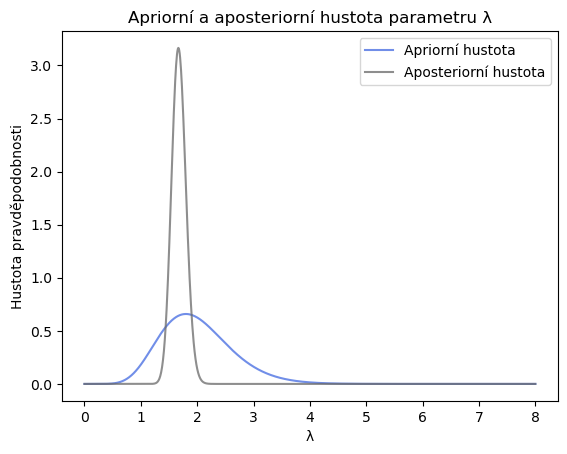

In [4]:
alpha_prior = 10
beta_prior = 5

alpha_posterior = alpha_prior + sum(observations)
beta_posterior = beta_prior + len(observations)

print('apriorní:')
print('-----------')
print('alfa: ' + str(alpha_prior))
print('beta: ' + str(beta_prior))
print('aposteriorní:')
print('-----------')
print('alfa: ' + str(alpha_posterior))
print('beta: ' + str(beta_posterior))

x = np.linspace(0, 8, 1000)

pdf_prior = stats.gamma.pdf(x, alpha_prior, scale=1/beta_prior)
pdf_posterior = stats.gamma.pdf(x, alpha_posterior, scale=1/beta_posterior)

fig, ax = plt.subplots(1, 1)
plt.title('Apriorní a aposteriorní hustota parametru λ')
ax.plot(x, pdf_prior, color='royalblue', label='Apriorní hustota', alpha=0.75)
ax.plot(x, pdf_posterior, color='dimgray', label='Aposteriorní hustota', alpha=0.75)
ax.legend(loc='best')
plt.xlabel('λ')
plt.ylabel('Hustota pravděpodobnosti')
plt.show()

#### Prediktivní rozdělení (pozorování)

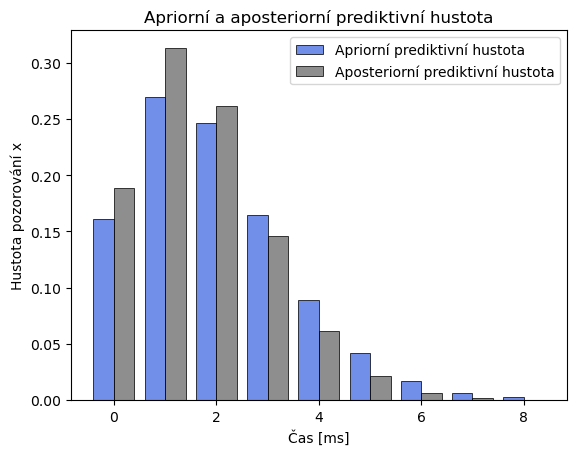

In [5]:
x = np.arange(0, 9)

pmf_prior = stats.nbinom.pmf(x, alpha_prior, beta_prior/(1 + beta_prior))
pmf_posterior = stats.nbinom.pmf(x, alpha_posterior, beta_posterior/(1 + beta_posterior))

fig, ax = plt.subplots(1, 1)
plt.title('Apriorní a aposteriorní prediktivní hustota')
# plt.plot(x, pmf_prior, 'o', color='royalblue', label='Apriorní prediktivní hustota')
plt.bar(x - 0.2, pmf_prior, width=0.4, color='royalblue', edgecolor = 'black', linewidth=0.7, label='Apriorní prediktivní hustota', alpha=0.75)
# plt.plot(x, pmf_posterior, 'o', color='dimgray', label='Aposteriorní prediktivní hustota')
plt.bar(x + 0.2, pmf_posterior, width=0.4, color='dimgray', edgecolor = 'black', linewidth=0.7, label='Aposteriorní prediktivní hustota', alpha=0.75)
ax.legend(loc='best')
plt.xlabel('Čas [ms]')
plt.ylabel('Hustota pozorování x')
plt.show()

#### 95% interval spolehlivosti

In [6]:
low_prior = stats.gamma.ppf(0.025, alpha_prior, scale=1/beta_prior)
high_prior = stats.gamma.ppf(0.975, alpha_prior, scale=1/beta_prior)

low_posterior = stats.gamma.ppf(0.025, alpha_posterior, scale=1/beta_posterior)
high_posterior = stats.gamma.ppf(0.975, alpha_posterior, scale=1/beta_posterior)

print("Apriorní:")
print(low_prior, high_prior)
print("Aposteriorní:")
print(low_posterior, high_posterior)
# TODO posterior

Apriorní:
0.9590777392264868 3.416960690283833
Aposteriorní:
1.4376938284869922 1.9327207471868797


In [7]:
mean = alpha_posterior / beta_posterior
median = stats.gamma.ppf(0.5, a=alpha_posterior, scale=1/beta_posterior)

print(mean, median)

1.6761904761904762 1.6730169441241727


In [8]:
mean_2_prior = stats.nbinom.mean(alpha_prior,  beta_prior / (beta_prior + 1))
mean_2_pos = stats.nbinom.mean(alpha_posterior,  beta_posterior / (beta_posterior + 1))

print("Apriorní:")
print(mean_2_prior)

print("Aposteriorní:")
print(mean_2_pos)

Apriorní:
1.9999999999999996
Aposteriorní:
1.6761904761904758


#### Aproximace diskrétním rozdělením

In [9]:
# Apriorní informace
MEASUREMENTS_COUNT = 100000
measured_vals_prior = df_1[['skupina', 'uloha_1 b)_prior']][:MEASUREMENTS_COUNT]
measured_vals_prior

,skupina,uloha_1 b)_prior
0,0,3.634785
1,0,2.868113
2,0,2.149160
3,0,4.263065
4,0,2.594745
...,...,...
99995,9999,1.725637
99996,9999,4.048414
99997,9999,3.000662
99998,9999,3.058451


In [10]:
# Rozdělení procesu
process_distribution = df_1['uloha_1 b)_pozorování'][:OBSERVATIONS_COUNT]
process_distribution

0     3.626656
1     3.008269
2     2.989829
3     2.371630
4     4.009366
        ...   
95    3.438933
96    3.430973
97    3.727306
98    4.257909
99    2.081679
Name: uloha_1 b)_pozorování, Length: 100, dtype: float64

In [11]:
# Parametr b
# measured_vals_prior['group'] = [i/10 for i in range(MEASUREMENTS_COUNT)]
#df['count_max'] = df.groupby(['Sp', 'Mt'])['count'].transform(max)
# measured_vals_prior
a = 1
mu = 3
sigma_sqr = 1
a_norm = (a - mu) / sigma_sqr

groups = measured_vals_prior.groupby('skupina')['uloha_1 b)_prior'].max()

hist, bins = np.histogram(groups, bins=50)
hist = hist / 10000

bins_centers = []

for j in range(1, len(bins)):
    b_j = (bins[j - 1] + bins[j]) / 2
    bins_centers.append(b_j)

divider_sum = 0

for i in range(len(bins)):
    b_j = (bins[i - 1] + bins[i]) / 2
    b_norm = (b_j - mu) / sigma_sqr
    divider_sum = divider_sum + np.prod([stats.truncnorm.pdf(data, a_norm, b_norm, mu, sigma_sqr) for data in process_distribution])
    
posterior = []
likelihoods = []
for i in range(1, len(bins)):
    b_j = (bins[i - 1] + bins[i]) / 2
    b_norm = (b_j - mu) / sigma_sqr
    likelihood = np.prod([stats.truncnorm.pdf(data, a_norm, b_norm, mu, sigma_sqr) for data in process_distribution])
    
    likelihoods.append(likelihood)
    posterior.append((likelihood * hist[i-1]) / divider_sum)

likelihoods = likelihoods/sum(likelihoods)
posterior = posterior/sum(posterior)

print(hist)

print(likelihoods)

print(posterior)

[0.0003 0.0003 0.0003 0.0011 0.002  0.0037 0.0047 0.0068 0.0091 0.0115
 0.016  0.0225 0.0241 0.0324 0.0387 0.037  0.0496 0.0477 0.0555 0.0581
 0.0565 0.0531 0.0533 0.0507 0.0516 0.0435 0.0412 0.0366 0.0311 0.0237
 0.0225 0.0203 0.0161 0.0153 0.0115 0.0098 0.0101 0.0061 0.0065 0.0043
 0.0036 0.0023 0.0027 0.0016 0.0013 0.001  0.001  0.0005 0.0004 0.0004]
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.06080918 0.05586125
 0.05226924 0.04963764 0.04769849 0.04626526 0.04520517 0.04442194
 0.04384474 0.04342097 0.04311131 0.04288626 0.04272366 0.04260695
 0.04252373 0.04246482 0.0424234  0.0423945  0.04237448 0.04236072
 0.04235133 0.04234497]
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0

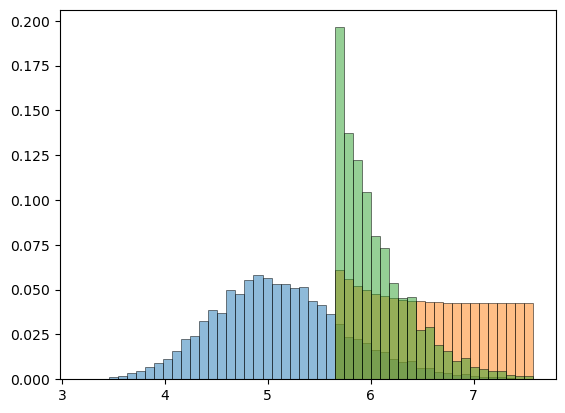

In [12]:


fig, ax = plt.subplots(1, 1)
# plt.title('Apriorní a aposteriorní prediktivní hustota')
# plt.plot(x, pmf_prior, 'o', color='royalblue', label='Apriorní prediktivní hustota')
# plt.plot(x, pmf_posterior, 'o', color='dimgray', label='Aposteriorní prediktivní hustota')
# ax.legend(loc='best')
# plt.xlabel('Čas [ms]')
# plt.ylabel('Hustota pozorování x')

# print(len(hist), len(bins_centers))

plt.bar(bins_centers, hist, width=bins_centers[1]-bins_centers[0], alpha=0.5, label='Aposteriorní hustota', edgecolor='black', linewidth=0.7)
plt.bar(bins_centers, likelihoods, width=bins_centers[1]-bins_centers[0], alpha=0.5, label='Aposteriorní hustota', edgecolor='black', linewidth=0.7)
plt.bar(bins_centers, posterior, width=bins_centers[1]-bins_centers[0], alpha=0.5, label='Aposteriorní hustota', edgecolor='black', linewidth=0.7)

# ax.hist(groups, bins=50, edgecolor='black', linewidth=0.7, density=True)
# ax.bar(bins_centers, likelihoods, bins=22, edgecolor='black', linewidth=0.7, density=True)
plt.show()
# ax.hist(d["time"], label=conf, bins=200)

In [13]:
# Seřazení aposteriorní hustoty vzestupně
# sorted_posterior = np.sort(posterior)
# sorted_posterior = posterior
# Výpočet kumulativní distribuční funkce (CDF)
cdf = np.cumsum(posterior)

# Hledání hodnot na krajích 95% intervalu spolehlivosti
lower_bound = bins_centers[np.where(cdf >= 0.025)[0][0]]
upper_bound = bins_centers[np.where(cdf >= 0.975)[0][0]]

print("95% Interval spolehlivosti pro parametr b:")
print(f"Lower Bound: {lower_bound}")
print(f"Upper Bound: {upper_bound}")

95% Interval spolehlivosti pro parametr b:
Lower Bound: 5.693712028182375
Upper Bound: 7.008910628347767


In [14]:
# TODO 1a) 5. úkol - Bodový odhad se má dělat pomocí negativního binomického rozdělení
mean = sum(bins_centers * posterior)

median_index = np.where(cdf >= 0.5)[0][0]
median = bins_centers[median_index]

median

print(mean, median)

6.052771319832352 5.956751748215453


## Úloha 2 - Regrese

In [32]:
df_2 = pd.read_excel(open('Projekt-2_Data.xlsx', 'rb'), sheet_name='Úloha 2')
df_2 = df_2.rename(columns={'Ping [ms]' : 'Ping'})
df_2

,OSType,ActiveUsers,InteractingPct,ScrollingPct,Ping
0,iOS,4113,0.8283,0.1717,47
1,iOS,7549,0.3461,0.6539,46
2,Windows,8855,0.2178,0.7822,55
3,Android,8870,0.0794,0.9206,56
4,MacOS,9559,0.7282,0.2718,76
...,...,...,...,...,...
497,iOS,5315,0.1974,0.8026,28
498,MacOS,1392,0.2373,0.7627,24
499,iOS,6014,0.8112,0.1888,54
500,Android,5118,0.2345,0.7655,39


In [ ]:
from matplotlib import cm

fig = plt.figure() 
ax = fig.add_subplot(111, projection='3d')

# active_users_min = min(df_2.ActiveUsers)
active_users_max = max(df_2.ActiveUsers)

x = np.arange(0, 10000, 100)
y = np.arange(0.0, 1.0, 0.01)
X, Y = np.meshgrid(x, y)

print(full_model_fit.params)

zs_macos = full_model_fit.params['Intercept'] + \
    full_model_fit.params['MacOS'] + \
    full_model_fit.params['ActiveUsers'] * X + \
    full_model_fit.params['ActiveUsers_MacOS'] * X + \
    full_model_fit.params['InteractingPct'] * Y + \
    full_model_fit.params['InteractingPct_MacOS'] * Y + \
    full_model_fit.params['ActiveUsers_InteractingPct'] * X * Y + \
    full_model_fit.params['ActiveUsers_ActiveUsers'] * X * X + \
    full_model_fit.params['InteractingPct_InteractingPct'] * Y * Y

zs_win = full_model_fit.params['Intercept'] + \
    full_model_fit.params['Windows'] + \
    full_model_fit.params['ActiveUsers'] * X + \
    full_model_fit.params['ActiveUsers_Windows'] * X + \
    full_model_fit.params['InteractingPct'] * Y + \
    full_model_fit.params['InteractingPct_Windows'] * Y + \
    full_model_fit.params['ActiveUsers_InteractingPct'] * X * Y + \
    full_model_fit.params['ActiveUsers_ActiveUsers'] * X * X + \
    full_model_fit.params['InteractingPct_InteractingPct'] * Y * Y

zs_ios = full_model_fit.params['Intercept'] + \
    full_model_fit.params['iOS'] + \
    full_model_fit.params['ActiveUsers'] * X + \
    full_model_fit.params['ActiveUsers_iOS'] * X + \
    full_model_fit.params['InteractingPct'] * Y + \
    full_model_fit.params['InteractingPct_iOS'] * Y + \
    full_model_fit.params['ActiveUsers_InteractingPct'] * X * Y + \
    full_model_fit.params['ActiveUsers_ActiveUsers'] * X * X + \
    full_model_fit.params['InteractingPct_InteractingPct'] * Y * Y

zs_android = full_model_fit.params['Intercept'] + \
    full_model_fit.params['ActiveUsers'] * X + \
    full_model_fit.params['InteractingPct'] * Y + \
    full_model_fit.params['ActiveUsers_InteractingPct'] * X * Y + \
    full_model_fit.params['ActiveUsers_ActiveUsers'] * X * X + \
    full_model_fit.params['InteractingPct_InteractingPct'] * Y * Y

Z_macos = zs_macos.reshape(X.shape)
Z_win = zs_win.reshape(X.shape)
Z_ios = zs_ios.reshape(X.shape)
Z_android = zs_android.reshape(X.shape)

# Vykresleni puvodnich dat
# ax.scatter(df_2.ActiveUsers, df_2.InteractingPct, df_2.Ping, marker='.')

# ax.legend()
# ax.view_init(elev=20., azim=-35, roll=0)
# ax.set_xlim(0, 1)
# ax.set_ylim(0, 1)
# ax.set_zlim(0, 1)

#ax.set_xlabel('X')
#ax.set_ylabel('Y')
#ax.set_zlabel('Z')
plt.show()

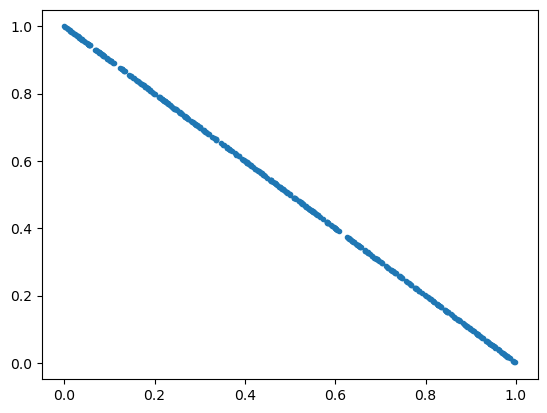

                            OLS Regression Results                            
Dep. Variable:                   Ping   R-squared:                       0.166
Model:                            OLS   Adj. R-squared:                  0.164
Method:                 Least Squares   F-statistic:                     99.24
Date:                Fri, 15 Dec 2023   Prob (F-statistic):           1.91e-21
Time:                        14:34:14   Log-Likelihood:                -2019.0
No. Observations:                 502   AIC:                             4042.
Df Residuals:                     500   BIC:                             4050.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         33.8517      0.403     84.

In [16]:
# Ukázání závislosti reziduí
fig = plt.figure()
plt.scatter(df_2.InteractingPct, df_2.ScrollingPct, marker='.')
plt.show()

model2DM1=smf.ols(formula='Ping~InteractingPct + ScrollingPct',data=df_2)
results2DM1=model2DM1.fit()
print(results2DM1.summary())


model2DM2=smf.ols(formula='Ping~InteractingPct',data=df_2)
results2DM2=model2DM2.fit()
print(results2DM2.summary())


model2DM3=smf.ols(formula='Ping~ScrollingPct',data=df_2)
results2DM3=model2DM3.fit()
print(results2DM3.summary())

In [17]:
def one_hot_enc(df, column):
    if column in df:
        one_hot = pd.get_dummies(df[column], dtype=float)
        df = df.drop(column, axis = 1)
        return df.join(one_hot)

    return df

df_2 = one_hot_enc(df_2, 'OSType')
df_2

,ActiveUsers,InteractingPct,ScrollingPct,Ping,Android,MacOS,Windows,iOS
0,4113,0.8283,0.1717,47,0.0,0.0,0.0,1.0
1,7549,0.3461,0.6539,46,0.0,0.0,0.0,1.0
2,8855,0.2178,0.7822,55,0.0,0.0,1.0,0.0
3,8870,0.0794,0.9206,56,1.0,0.0,0.0,0.0
4,9559,0.7282,0.2718,76,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...
497,5315,0.1974,0.8026,28,0.0,0.0,0.0,1.0
498,1392,0.2373,0.7627,24,0.0,1.0,0.0,0.0
499,6014,0.8112,0.1888,54,0.0,0.0,0.0,1.0
500,5118,0.2345,0.7655,39,1.0,0.0,0.0,0.0


In [18]:
def add_mul_column(df, first_col, second_col):
    new_col_name = first_col + '_' + second_col
    
    if new_col_name not in df:
        df.insert(loc=len(df.columns), column=new_col_name, value=df[first_col] * df[second_col])
        return df
    
    return df

df_2 = add_mul_column(df_2, 'ActiveUsers', 'InteractingPct')
df_2 = add_mul_column(df_2, 'ActiveUsers', 'MacOS')
df_2 = add_mul_column(df_2, 'ActiveUsers', 'Windows')
df_2 = add_mul_column(df_2, 'ActiveUsers', 'iOS')
df_2 = add_mul_column(df_2, 'InteractingPct', 'MacOS')
df_2 = add_mul_column(df_2, 'InteractingPct', 'Windows')
df_2 = add_mul_column(df_2, 'InteractingPct', 'iOS')

df_2 = add_mul_column(df_2, 'ActiveUsers', 'ActiveUsers')
df_2 = add_mul_column(df_2, 'InteractingPct', 'InteractingPct')

df_2

,ActiveUsers,InteractingPct,ScrollingPct,Ping,Android,MacOS,Windows,iOS,ActiveUsers_InteractingPct,ActiveUsers_MacOS,ActiveUsers_Windows,ActiveUsers_iOS,InteractingPct_MacOS,InteractingPct_Windows,InteractingPct_iOS,ActiveUsers_ActiveUsers,InteractingPct_InteractingPct
0,4113,0.8283,0.1717,47,0.0,0.0,0.0,1.0,3406.7979,0.0,0.0,4113.0,0.0000,0.0000,0.8283,16916769,0.686081
1,7549,0.3461,0.6539,46,0.0,0.0,0.0,1.0,2612.7089,0.0,0.0,7549.0,0.0000,0.0000,0.3461,56987401,0.119785
2,8855,0.2178,0.7822,55,0.0,0.0,1.0,0.0,1928.6190,0.0,8855.0,0.0,0.0000,0.2178,0.0000,78411025,0.047437
3,8870,0.0794,0.9206,56,1.0,0.0,0.0,0.0,704.2780,0.0,0.0,0.0,0.0000,0.0000,0.0000,78676900,0.006304
4,9559,0.7282,0.2718,76,0.0,1.0,0.0,0.0,6960.8638,9559.0,0.0,0.0,0.7282,0.0000,0.0000,91374481,0.530275
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
497,5315,0.1974,0.8026,28,0.0,0.0,0.0,1.0,1049.1810,0.0,0.0,5315.0,0.0000,0.0000,0.1974,28249225,0.038967
498,1392,0.2373,0.7627,24,0.0,1.0,0.0,0.0,330.3216,1392.0,0.0,0.0,0.2373,0.0000,0.0000,1937664,0.056311
499,6014,0.8112,0.1888,54,0.0,0.0,0.0,1.0,4878.5568,0.0,0.0,6014.0,0.0000,0.0000,0.8112,36168196,0.658045
500,5118,0.2345,0.7655,39,1.0,0.0,0.0,0.0,1200.1710,0.0,0.0,0.0,0.0000,0.0000,0.0000,26193924,0.054990


In [19]:
# Definice plneho modelu
# formula_definition = 'Ping ~ ActiveUsers + InteractingPct + C(OSType) + ' + \
#     'ActiveUsers * InteractingPct + ' + \
#     'ActiveUsers * C(OSType) + ' + \
#     'InteractingPct * C(OSType) + ' + \
#     '+ I(ActiveUsers**2) + I(InteractingPct**2)'
# full_model = smf.ols(formula=formula_definition, data=df_2)
# full_model_fit = full_model.fit()
# full_model_fit.summary()

formula_definition = 'Ping ~ ActiveUsers + InteractingPct + MacOS + Windows + iOS + ' + \
    'ActiveUsers_InteractingPct + ' + \
    'ActiveUsers_MacOS + ' + \
    'ActiveUsers_Windows + ' + \
    'ActiveUsers_iOS + ' + \
    'InteractingPct_MacOS + ' + \
    'InteractingPct_Windows + ' + \
    'InteractingPct_iOS + ' + \
    'ActiveUsers_ActiveUsers + ' + \
    'InteractingPct_InteractingPct'
full_model = smf.ols(formula=formula_definition, data=df_2)
full_model_fit = full_model.fit()
full_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Ping   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     187.9
Date:                Fri, 15 Dec 2023   Prob (F-statistic):          5.18e-186
Time:                        14:34:14   Log-Likelihood:                -1598.4
No. Observations:                 502   AIC:                             3227.
Df Residuals:                     487   BIC:                             3290.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        -0.3388      2.354     -0.144      0.886      -4.965       4.287
ActiveUsers                       0.0100      0.001     17.571      0.000       0.009       0.011
InteractingPct                   37.6062      4.567      8.234      0.000      28.633      46.580
MacOS                             2.0017      2.260      0.886      0.376      -2.440       6.443
Windows                           7.8174      2.217      3.526      0.000       3.461      12.174
iOS                              -0.0483      2.265     -0.021      0.983      -4.499       4.403
ActiveUsers_InteractingPct       -0.0031      0.000     -8.532      0.000      -0.004      -0.002
ActiveUsers_MacOS                 0.0014      0.000      4.536      0.000       0.001       0.002
ActiveUsers_Windows              -0.0008      0.000     -2.505      0.013      -0.001      -0.000
ActiveUsers_iOS                  -0.0011      0.000     -3.369      0.001      -0.002      -0.000
InteractingPct_MacOS             -0.3566      2.530     -0.141      0.888      -5.327       4.614
InteractingPct_Windows            0.4260      2.721      0.157      0.876      -4.919       5.771
InteractingPct_iOS                0.2678      2.691      0.100      0.921      -5.020       5.556
ActiveUsers_ActiveUsers        -4.17e-07    4.4e-08     -9.469      0.000   -5.03e-07    -3.3e-07
InteractingPct_InteractingPct    -3.7258      3.492     -1.067      0.287     -10.587       3.135
==============================================================================
Omnibus:                      228.442   Durbin-Watson:                   1.933
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3152.488
Skew:                           1.603   Prob(JB):                         0.00
Kurtosis:                      14.851   Cond. No.                     1.06e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.06e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [20]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

#upozorni na významnost koeficientů, R^2 atp
# získej VIF a slož všechny VIF do dataframe
X = pd.DataFrame(full_model.exog, columns=full_model.exog_names)
vif = pd.Series([variance_inflation_factor(X.values, i) 
                 for i in range(X.shape[1])], 
                 index=X.columns)
vif_df = vif.to_frame()
# Nastavení názvu sloupce
vif_df.columns = ['VIF']
print('\n\n\n')
print(vif_df)
#ukaž korelaci prediktorů
print('\n\n\n')
print(X.corr()) 





                                     VIF
Intercept                      79.081437
ActiveUsers                    30.108570
InteractingPct                 26.021105
MacOS                          14.530955
Windows                        13.726080
iOS                            13.164975
ActiveUsers_InteractingPct      8.851002
ActiveUsers_MacOS              10.454073
ActiveUsers_Windows            10.189613
ActiveUsers_iOS                 9.061267
InteractingPct_MacOS            7.586537
InteractingPct_Windows          6.857633
InteractingPct_iOS              6.028016
ActiveUsers_ActiveUsers        22.499134
InteractingPct_InteractingPct  16.060875




                               Intercept  ActiveUsers  InteractingPct  \
Intercept                            NaN          NaN             NaN   
ActiveUsers                          NaN     1.000000        0.040275   
InteractingPct                       NaN     0.040275        1.000000   
MacOS                                NaN    

Intercept                       -3.388459e-01
ActiveUsers                      1.002406e-02
InteractingPct                   3.760617e+01
MacOS                            2.001747e+00
Windows                          7.817378e+00
iOS                             -4.833230e-02
ActiveUsers_InteractingPct      -3.086297e-03
ActiveUsers_MacOS                1.397350e-03
ActiveUsers_Windows             -7.618681e-04
ActiveUsers_iOS                 -1.058353e-03
InteractingPct_MacOS            -3.565678e-01
InteractingPct_Windows           4.260464e-01
InteractingPct_iOS               2.678486e-01
ActiveUsers_ActiveUsers         -4.169698e-07
InteractingPct_InteractingPct   -3.725768e+00
dtype: float64


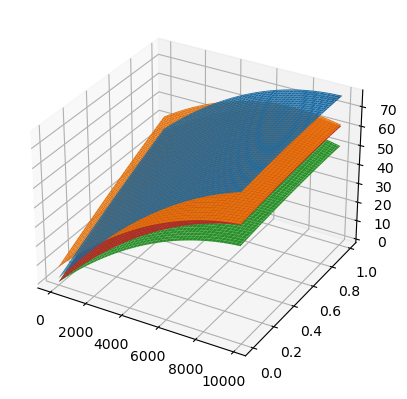

In [21]:
from matplotlib import cm

fig = plt.figure() 
ax = fig.add_subplot(111, projection='3d')

# active_users_min = min(df_2.ActiveUsers)
active_users_max = max(df_2.ActiveUsers)

x = np.arange(0, 10000, 100)
y = np.arange(0.0, 1.0, 0.01)
X, Y = np.meshgrid(x, y)

print(full_model_fit.params)

zs_macos = full_model_fit.params['Intercept'] + \
    full_model_fit.params['MacOS'] + \
    full_model_fit.params['ActiveUsers'] * X + \
    full_model_fit.params['ActiveUsers_MacOS'] * X + \
    full_model_fit.params['InteractingPct'] * Y + \
    full_model_fit.params['InteractingPct_MacOS'] * Y + \
    full_model_fit.params['ActiveUsers_InteractingPct'] * X * Y + \
    full_model_fit.params['ActiveUsers_ActiveUsers'] * X * X + \
    full_model_fit.params['InteractingPct_InteractingPct'] * Y * Y

zs_win = full_model_fit.params['Intercept'] + \
    full_model_fit.params['Windows'] + \
    full_model_fit.params['ActiveUsers'] * X + \
    full_model_fit.params['ActiveUsers_Windows'] * X + \
    full_model_fit.params['InteractingPct'] * Y + \
    full_model_fit.params['InteractingPct_Windows'] * Y + \
    full_model_fit.params['ActiveUsers_InteractingPct'] * X * Y + \
    full_model_fit.params['ActiveUsers_ActiveUsers'] * X * X + \
    full_model_fit.params['InteractingPct_InteractingPct'] * Y * Y

zs_ios = full_model_fit.params['Intercept'] + \
    full_model_fit.params['iOS'] + \
    full_model_fit.params['ActiveUsers'] * X + \
    full_model_fit.params['ActiveUsers_iOS'] * X + \
    full_model_fit.params['InteractingPct'] * Y + \
    full_model_fit.params['InteractingPct_iOS'] * Y + \
    full_model_fit.params['ActiveUsers_InteractingPct'] * X * Y + \
    full_model_fit.params['ActiveUsers_ActiveUsers'] * X * X + \
    full_model_fit.params['InteractingPct_InteractingPct'] * Y * Y

zs_android = full_model_fit.params['Intercept'] + \
    full_model_fit.params['ActiveUsers'] * X + \
    full_model_fit.params['InteractingPct'] * Y + \
    full_model_fit.params['ActiveUsers_InteractingPct'] * X * Y + \
    full_model_fit.params['ActiveUsers_ActiveUsers'] * X * X + \
    full_model_fit.params['InteractingPct_InteractingPct'] * Y * Y

Z_macos = zs_macos.reshape(X.shape)
Z_win = zs_win.reshape(X.shape)
Z_ios = zs_ios.reshape(X.shape)
Z_android = zs_android.reshape(X.shape)

# Vykresleni puvodnich dat
# ax.scatter(df_2.ActiveUsers, df_2.InteractingPct, df_2.Ping, marker='.')

ax.plot_surface(X, Y, Z_macos)
ax.plot_surface(X, Y, Z_win)
ax.plot_surface(X, Y, Z_ios)
ax.plot_surface(X, Y, Z_android)

# ax.legend()
# ax.view_init(elev=20., azim=-35, roll=0)
# ax.set_xlim(0, 1)
# ax.set_ylim(0, 1)
# ax.set_zlim(0, 1)

#ax.set_xlabel('X')
#ax.set_ylabel('Y')
#ax.set_zlabel('Z')
plt.show()

In [22]:
# Odstraneni iOS
formula_definition = 'Ping ~ ActiveUsers + InteractingPct + MacOS + Windows + ' + \
    'ActiveUsers_InteractingPct + ' + \
    'ActiveUsers_MacOS + ' + \
    'ActiveUsers_Windows + ' + \
    'ActiveUsers_iOS + ' + \
    'InteractingPct_MacOS + ' + \
    'InteractingPct_Windows + ' + \
    'InteractingPct_iOS + ' + \
    'ActiveUsers_ActiveUsers + ' + \
    'InteractingPct_InteractingPct'
model = smf.ols(formula=formula_definition, data=df_2)
model_fit = model.fit()
model_fit.summary()
# We need to select a significance level to stay in the model. (SL=0.05)

model_fit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Ping   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     202.8
Date:                Fri, 15 Dec 2023   Prob (F-statistic):          3.57e-187
Time:                        14:34:17   Log-Likelihood:                -1598.4
No. Observations:                 502   AIC:                             3225.
Df Residuals:                     488   BIC:                             3284.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        -0.3714      1.793     -0.207      0.836      -3.894       3.151
ActiveUsers                       0.0100      0.001     18.742      0.000       0.009       0.011
InteractingPct                   37.6338      4.375      8.603      0.000      29.038      46.229
MacOS                             2.0290      1.863      1.089      0.277      -1.632       5.690
Windows                           7.8447      1.810      4.335      0.000       4.289      11.400
ActiveUsers_InteractingPct       -0.0031      0.000     -8.590      0.000      -0.004      -0.002
ActiveUsers_MacOS                 0.0014      0.000      5.017      0.000       0.001       0.002
ActiveUsers_Windows              -0.0008      0.000     -2.796      0.005      -0.001      -0.000
ActiveUsers_iOS                  -0.0011      0.000     -5.155      0.000      -0.001      -0.001
InteractingPct_MacOS             -0.3729      2.408     -0.155      0.877      -5.104       4.358
InteractingPct_Windows            0.4095      2.605      0.157      0.875      -4.709       5.528
InteractingPct_iOS                0.2368      2.262      0.105      0.917      -4.208       4.682
ActiveUsers_ActiveUsers       -4.171e-07   4.38e-08     -9.524      0.000   -5.03e-07   -3.31e-07
InteractingPct_InteractingPct    -3.7327      3.473     -1.075      0.283     -10.557       3.092
==============================================================================
Omnibus:                      228.481   Durbin-Watson:                   1.933
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3153.673
Skew:                           1.603   Prob(JB):                         0.00
Kurtosis:                      14.853   Cond. No.                     9.61e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.61e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [23]:
# Odstraneni InteractingPct_iOS
formula_definition = 'Ping ~ ActiveUsers + InteractingPct + MacOS + Windows + ' + \
    'ActiveUsers_InteractingPct + ' + \
    'ActiveUsers_MacOS + ' + \
    'ActiveUsers_Windows + ' + \
    'ActiveUsers_iOS + ' + \
    'InteractingPct_MacOS + ' + \
    'InteractingPct_Windows + ' + \
    'ActiveUsers_ActiveUsers + ' + \
    'InteractingPct_InteractingPct'
model = smf.ols(formula=formula_definition, data=df_2)
model_fit = model.fit()
model_fit.summary()
# We need to select a significance level to stay in the model. (SL=0.05)

model_fit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Ping   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     220.1
Date:                Fri, 15 Dec 2023   Prob (F-statistic):          2.36e-188
Time:                        14:34:17   Log-Likelihood:                -1598.4
No. Observations:                 502   AIC:                             3223.
Df Residuals:                     489   BIC:                             3278.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        -0.3703      1.791     -0.207      0.836      -3.889       3.149
ActiveUsers                       0.0100      0.001     19.067      0.000       0.009       0.011
InteractingPct                   37.7781      4.148      9.108      0.000      29.628      45.928
MacOS                             2.0221      1.860      1.087      0.278      -1.633       5.677
Windows                           7.8395      1.807      4.338      0.000       4.289      11.390
ActiveUsers_InteractingPct       -0.0031      0.000     -8.657      0.000      -0.004      -0.002
ActiveUsers_MacOS                 0.0014      0.000      5.392      0.000       0.001       0.002
ActiveUsers_Windows              -0.0008      0.000     -2.941      0.003      -0.001      -0.000
ActiveUsers_iOS                  -0.0010      0.000     -8.061      0.000      -0.001      -0.001
InteractingPct_MacOS             -0.4989      2.084     -0.239      0.811      -4.593       3.595
InteractingPct_Windows            0.2836      2.308      0.123      0.902      -4.252       4.819
ActiveUsers_ActiveUsers       -4.168e-07   4.37e-08     -9.539      0.000   -5.03e-07   -3.31e-07
InteractingPct_InteractingPct    -3.7301      3.470     -1.075      0.283     -10.547       3.087
==============================================================================
Omnibus:                      228.487   Durbin-Watson:                   1.933
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3154.636
Skew:                           1.603   Prob(JB):                         0.00
Kurtosis:                      14.855   Cond. No.                     9.26e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.26e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [24]:
# Odstraneni InteractingPct_Windows
formula_definition = 'Ping ~ ActiveUsers + InteractingPct + MacOS + Windows + ' + \
    'ActiveUsers_InteractingPct + ' + \
    'ActiveUsers_MacOS + ' + \
    'ActiveUsers_Windows + ' + \
    'ActiveUsers_iOS + ' + \
    'InteractingPct_MacOS + ' + \
    'ActiveUsers_ActiveUsers + ' + \
    'InteractingPct_InteractingPct'
model = smf.ols(formula=formula_definition, data=df_2)
model_fit = model.fit()
model_fit.summary()
# We need to select a significance level to stay in the model. (SL=0.05)

model_fit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Ping   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     240.6
Date:                Fri, 15 Dec 2023   Prob (F-statistic):          1.50e-189
Time:                        14:34:17   Log-Likelihood:                -1598.4
No. Observations:                 502   AIC:                             3221.
Df Residuals:                     490   BIC:                             3271.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        -0.4127      1.756     -0.235      0.814      -3.862       3.037
ActiveUsers                       0.0100      0.001     19.086      0.000       0.009       0.011
InteractingPct                   37.8763      4.066      9.315      0.000      29.887      45.865
MacOS                             2.0635      1.828      1.129      0.259      -1.528       5.655
Windows                           7.9604      1.514      5.258      0.000       4.985      10.935
ActiveUsers_InteractingPct       -0.0031      0.000     -8.669      0.000      -0.004      -0.002
ActiveUsers_MacOS                 0.0014      0.000      5.401      0.000       0.001       0.002
ActiveUsers_Windows              -0.0008      0.000     -2.944      0.003      -0.001      -0.000
ActiveUsers_iOS                  -0.0010      0.000     -8.068      0.000      -0.001      -0.001
InteractingPct_MacOS             -0.5925      1.938     -0.306      0.760      -4.399       3.214
ActiveUsers_ActiveUsers       -4.168e-07   4.37e-08     -9.548      0.000   -5.03e-07   -3.31e-07
InteractingPct_InteractingPct    -3.7303      3.466     -1.076      0.282     -10.541       3.080
==============================================================================
Omnibus:                      228.480   Durbin-Watson:                   1.932
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3153.948
Skew:                           1.603   Prob(JB):                         0.00
Kurtosis:                      14.853   Cond. No.                     9.14e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.14e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [25]:
# Odstraneni InteractingPct_MacOS
formula_definition = 'Ping ~ ActiveUsers + InteractingPct + MacOS + Windows + ' + \
    'ActiveUsers_InteractingPct + ' + \
    'ActiveUsers_MacOS + ' + \
    'ActiveUsers_Windows + ' + \
    'ActiveUsers_iOS + ' + \
    'ActiveUsers_ActiveUsers + ' + \
    'InteractingPct_InteractingPct'
model = smf.ols(formula=formula_definition, data=df_2)
model_fit = model.fit()
model_fit.summary()
# We need to select a significance level to stay in the model. (SL=0.05)

model_fit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Ping   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     265.2
Date:                Fri, 15 Dec 2023   Prob (F-statistic):          9.41e-191
Time:                        14:34:17   Log-Likelihood:                -1598.5
No. Observations:                 502   AIC:                             3219.
Df Residuals:                     491   BIC:                             3265.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        -0.3369      1.736     -0.194      0.846      -3.749       3.075
ActiveUsers                       0.0100      0.001     19.112      0.000       0.009       0.011
InteractingPct                   37.7205      4.030      9.360      0.000      29.802      45.639
MacOS                             1.7623      1.538      1.146      0.252      -1.260       4.784
Windows                           7.9544      1.513      5.259      0.000       4.983      10.926
ActiveUsers_InteractingPct       -0.0031      0.000     -8.674      0.000      -0.004      -0.002
ActiveUsers_MacOS                 0.0014      0.000      5.404      0.000       0.001       0.002
ActiveUsers_Windows              -0.0008      0.000     -2.943      0.003      -0.001      -0.000
ActiveUsers_iOS                  -0.0010      0.000     -8.084      0.000      -0.001      -0.001
ActiveUsers_ActiveUsers        -4.17e-07   4.36e-08     -9.563      0.000   -5.03e-07   -3.31e-07
InteractingPct_InteractingPct    -3.7675      3.461     -1.089      0.277     -10.567       3.032
==============================================================================
Omnibus:                      229.699   Durbin-Watson:                   1.933
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3207.912
Skew:                           1.611   Prob(JB):                         0.00
Kurtosis:                      14.958   Cond. No.                     9.12e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.12e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [26]:
# Odstraneni InteractingPct_InteractingPct
formula_definition = 'Ping ~ ActiveUsers + InteractingPct + MacOS + Windows + ' + \
    'ActiveUsers_InteractingPct + ' + \
    'ActiveUsers_MacOS + ' + \
    'ActiveUsers_Windows + ' + \
    'ActiveUsers_iOS + ' + \
    'ActiveUsers_ActiveUsers'
model = smf.ols(formula=formula_definition, data=df_2)
model_fit = model.fit()
model_fit.summary()
# We need to select a significance level to stay in the model. (SL=0.05)

model_fit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Ping   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     294.4
Date:                Fri, 15 Dec 2023   Prob (F-statistic):          9.61e-192
Time:                        14:34:17   Log-Likelihood:                -1599.1
No. Observations:                 502   AIC:                             3218.
Df Residuals:                     492   BIC:                             3260.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      0.2577      1.649      0.156      0.876      -2.981       3.497
ActiveUsers                    0.0100      0.001     19.101      0.000       0.009       0.011
InteractingPct                33.9892      2.120     16.030      0.000      29.823      38.155
MacOS                          1.6826      1.537      1.095      0.274      -1.337       4.702
Windows                        7.9718      1.513      5.270      0.000       5.000      10.944
ActiveUsers_InteractingPct    -0.0031      0.000     -8.677      0.000      -0.004      -0.002
ActiveUsers_MacOS              0.0014      0.000      5.430      0.000       0.001       0.002
ActiveUsers_Windows           -0.0007      0.000     -2.919      0.004      -0.001      -0.000
ActiveUsers_iOS               -0.0010      0.000     -8.079      0.000      -0.001      -0.001
ActiveUsers_ActiveUsers    -4.163e-07   4.36e-08     -9.547      0.000   -5.02e-07   -3.31e-07
==============================================================================
Omnibus:                      230.835   Durbin-Watson:                   1.928
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3266.312
Skew:                           1.617   Prob(JB):                         0.00
Kurtosis:                      15.070   Cond. No.                     4.22e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.22e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [27]:
# Odstraneni MacOS
formula_definition = 'Ping ~ ActiveUsers + InteractingPct + Windows + ' + \
    'ActiveUsers_InteractingPct + ' + \
    'ActiveUsers_MacOS + ' + \
    'ActiveUsers_Windows + ' + \
    'ActiveUsers_iOS + ' + \
    'ActiveUsers_ActiveUsers'
model = smf.ols(formula=formula_definition, data=df_2)
model_fit = model.fit()
model_fit.summary()
# We need to select a significance level to stay in the model. (SL=0.05)

model_fit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Ping   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     330.9
Date:                Fri, 15 Dec 2023   Prob (F-statistic):          9.30e-193
Time:                        14:34:17   Log-Likelihood:                -1599.7
No. Observations:                 502   AIC:                             3217.
Df Residuals:                     493   BIC:                             3255.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      0.7923      1.575      0.503      0.615      -2.302       3.887
ActiveUsers                    0.0099      0.001     19.167      0.000       0.009       0.011
InteractingPct                34.2568      2.107     16.262      0.000      30.118      38.396
Windows                        7.3575      1.405      5.236      0.000       4.597      10.118
ActiveUsers_InteractingPct    -0.0031      0.000     -8.832      0.000      -0.004      -0.002
ActiveUsers_MacOS              0.0017      0.000     13.603      0.000       0.001       0.002
ActiveUsers_Windows           -0.0007      0.000     -2.710      0.007      -0.001      -0.000
ActiveUsers_iOS               -0.0011      0.000     -8.118      0.000      -0.001      -0.001
ActiveUsers_ActiveUsers    -4.146e-07   4.36e-08     -9.511      0.000      -5e-07   -3.29e-07
==============================================================================
Omnibus:                      242.580   Durbin-Watson:                   1.931
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3742.643
Skew:                           1.701   Prob(JB):                         0.00
Kurtosis:                      15.937   Cond. No.                     4.21e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.21e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [28]:
# Odstraneni ActiveUsers_ActiveUsers
formula_definition = 'Ping ~ ActiveUsers + InteractingPct + Windows + ' + \
    'ActiveUsers_InteractingPct + ' + \
    'ActiveUsers_MacOS + ' + \
    'ActiveUsers_Windows + ' + \
    'ActiveUsers_iOS'
model = smf.ols(formula=formula_definition, data=df_2)
model_fit = model.fit()
model_fit.summary()
# We need to select a significance level to stay in the model. (SL=0.05)

model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Ping   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                     309.3
Date:                Fri, 15 Dec 2023   Prob (F-statistic):          4.99e-176
Time:                        14:34:17   Log-Likelihood:                -1642.0
No. Observations:                 502   AIC:                             3300.
Df Residuals:                     494   BIC:                             3334.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      9.9196      1.357      7.309      0.000       7.253      12.586
ActiveUsers                    0.0055      0.000     22.743      0.000       0.005       0.006
InteractingPct                35.2710      2.286     15.426      0.000      30.779      39.763
Windows                        7.7665      1.526      5.088      0.000       4.767      10.766
ActiveUsers_InteractingPct    -0.0033      0.000     -8.504      0.000      -0.004      -0.003
ActiveUsers_MacOS              0.0017      0.000     12.726      0.000       0.001       0.002
ActiveUsers_Windows           -0.0007      0.000     -2.840      0.005      -0.001      -0.000
ActiveUsers_iOS               -0.0010      0.000     -7.445      0.000      -0.001      -0.001
==============================================================================
Omnibus:                      123.688   Durbin-Watson:                   1.872
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              663.242
Skew:                           0.959   Prob(JB):                    9.53e-145
Kurtosis:                       8.294   Cond. No.                     6.56e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.56e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [29]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

#upozorni na významnost koeficientů, R^2 atp
# získej VIF a slož všechny VIF do dataframe
X = pd.DataFrame(model.exog, columns=model.exog_names)
vif = pd.Series([variance_inflation_factor(X.values, i) 
                 for i in range(X.shape[1])], 
                 index=X.columns)
vif_df = vif.to_frame()
# Nastavení názvu sloupce
vif_df.columns = ['VIF']
print('\n\n\n')
print(vif_df)
#ukaž korelaci prediktorů
print('\n\n\n')
print(X.corr()) 





                                  VIF
Intercept                   22.411971
ActiveUsers                  4.567019
InteractingPct               5.561726
Windows                      5.546736
ActiveUsers_InteractingPct   8.550677
ActiveUsers_MacOS            1.656643
ActiveUsers_Windows          6.464752
ActiveUsers_iOS              1.550671




                            Intercept  ActiveUsers  InteractingPct   Windows  \
Intercept                         NaN          NaN             NaN       NaN   
ActiveUsers                       NaN     1.000000        0.040275  0.003135   
InteractingPct                    NaN     0.040275        1.000000 -0.016964   
Windows                           NaN     0.003135       -0.016964  1.000000   
ActiveUsers_InteractingPct        NaN     0.591746        0.752979  0.002608   
ActiveUsers_MacOS                 NaN     0.243697        0.072359 -0.327426   
ActiveUsers_Windows               NaN     0.258029        0.010807  0.875271   
ActiveUser

Intercept                      9.919642
ActiveUsers                    0.005472
InteractingPct                35.271023
Windows                        7.766522
ActiveUsers_InteractingPct    -0.003274
ActiveUsers_MacOS              0.001690
ActiveUsers_Windows           -0.000745
ActiveUsers_iOS               -0.001048
dtype: float64


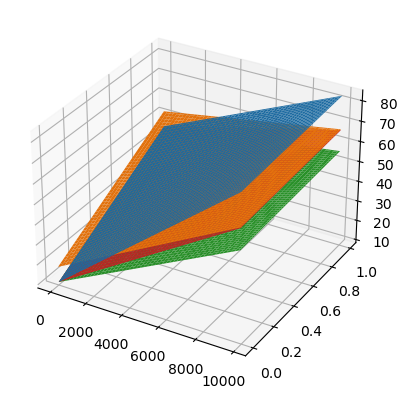

In [31]:
from matplotlib import cm

fig = plt.figure() 
ax = fig.add_subplot(111, projection='3d')

# active_users_min = min(df_2.ActiveUsers)
active_users_max = max(df_2.ActiveUsers)

x = np.arange(0, 10000, 100)
y = np.arange(0.0, 1.0, 0.01)
X, Y = np.meshgrid(x, y)

print(model_fit.params)

zs_macos = model_fit.params['Intercept'] + \
    model_fit.params['ActiveUsers'] * X + \
    model_fit.params['ActiveUsers_MacOS'] * X + \
    model_fit.params['InteractingPct'] * Y + \
    model_fit.params['ActiveUsers_InteractingPct'] * X * Y
    # model_fit.params['ActiveUsers_ActiveUsers'] * X * X
    # model_fit.params['InteractingPct_InteractingPct'] * Y * Y
    # model_fit.params['MacOS'] + \
    # model_fit.params['InteractingPct_MacOS'] * Y + \

zs_win = model_fit.params['Intercept'] + \
    model_fit.params['Windows'] + \
    model_fit.params['ActiveUsers'] * X + \
    model_fit.params['ActiveUsers_Windows'] * X + \
    model_fit.params['InteractingPct'] * Y + \
    model_fit.params['ActiveUsers_InteractingPct'] * X * Y
    # model_fit.params['ActiveUsers_ActiveUsers'] * X * X 
    # model_fit.params['InteractingPct_Windows'] * Y + \
    # model_fit.params['InteractingPct_InteractingPct'] * Y * Y

zs_ios = model_fit.params['Intercept'] + \
    model_fit.params['ActiveUsers'] * X + \
    model_fit.params['ActiveUsers_iOS'] * X + \
    model_fit.params['InteractingPct'] * Y + \
    model_fit.params['ActiveUsers_InteractingPct'] * X * Y
    # model_fit.params['ActiveUsers_ActiveUsers'] * X * X
    # model_fit.params['iOS'] + \
    # model_fit.params['InteractingPct_iOS'] * Y + \
    # model_fit.params['InteractingPct_InteractingPct'] * Y * Y

zs_android = model_fit.params['Intercept'] + \
    model_fit.params['ActiveUsers'] * X + \
    model_fit.params['InteractingPct'] * Y + \
    model_fit.params['ActiveUsers_InteractingPct'] * X * Y
    # model_fit.params['ActiveUsers_ActiveUsers'] * X * X
    # model_fit.params['InteractingPct_InteractingPct'] * Y * Y

Z_macos = zs_macos.reshape(X.shape)
Z_win = zs_win.reshape(X.shape)
Z_ios = zs_ios.reshape(X.shape)
Z_android = zs_android.reshape(X.shape)

# Vykresleni puvodnich dat
# ax.scatter(df_2.ActiveUsers, df_2.InteractingPct, df_2.Ping, marker='.')

ax.plot_surface(X, Y, Z_macos)
ax.plot_surface(X, Y, Z_win)
ax.plot_surface(X, Y, Z_ios)
ax.plot_surface(X, Y, Z_android)

# ax.legend()
# ax.view_init(elev=20., azim=-35, roll=0)
# ax.set_xlim(0, 1)
# ax.set_ylim(0, 1)
# ax.set_zlim(0, 1)

#ax.set_xlabel('X')
#ax.set_ylabel('Y')
#ax.set_zlabel('Z')
plt.show()